In [32]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from datetime import datetime

## Load Data 

In [100]:
# Step 1: Download S&P 500 data for the last year
start = datetime(2010, 1,1)
end = datetime(2024, 9, 10)
snp = yf.Ticker('^GSPC')
data = snp.history(start=start, end=end)

# Step 2: Compute log returns
data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1)).dropna()
log_returns = data['Log_Returns'].dropna()

data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log_Returns
Date,,,,,,,,
2010-01-04 00:00:00-05:00,1116.560059,1133.869995,1116.560059,1132.989990,3991400000,0.0,0.0,NaN
2010-01-05 00:00:00-05:00,1132.660034,1136.630005,1129.660034,1136.520020,2491020000,0.0,0.0,0.003111
2010-01-06 00:00:00-05:00,1135.709961,1139.189941,1133.949951,1137.140015,4972660000,0.0,0.0,0.000545
2010-01-07 00:00:00-05:00,1136.270020,1142.459961,1131.319946,1141.689941,5270680000,0.0,0.0,0.003993
2010-01-08 00:00:00-05:00,1140.520020,1145.390015,1136.219971,1144.979980,4389590000,0.0,0.0,0.002878


## Fit GARCH model

Fit baseline model using entire time series and plot the in sample (predicted) conditional volatility 

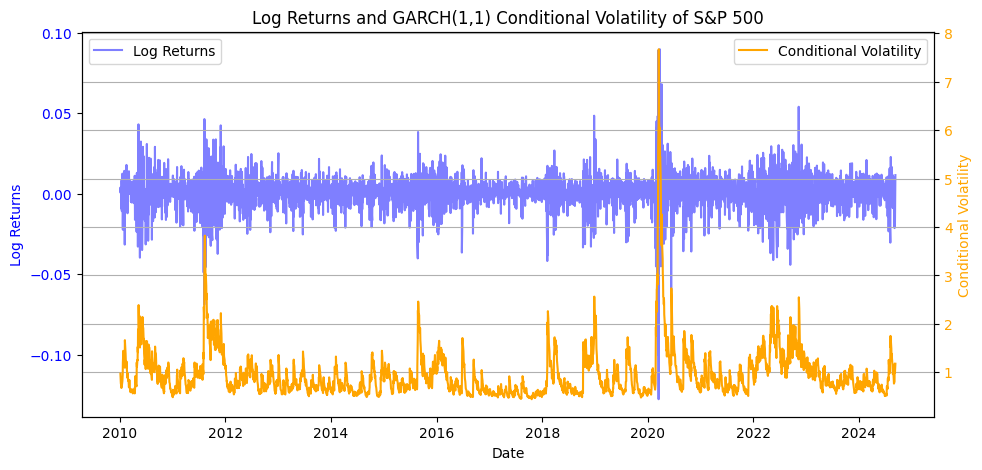

In [101]:
# Step 3: Fit a GARCH(1,1) model
model = arch_model(100*log_returns, vol='GARCH', mean='AR', p=1, q=1)
garch_fit = model.fit(disp='off')

# Step 4: Extract the conditional volatility
conditional_volatility = garch_fit.conditional_volatility

# Step 5: Plot log returns and conditional volatility on the same axis
fig, ax1 = plt.subplots(figsize=(11, 5))

# Plot log returns
ax1.plot(data.index[1:], log_returns, label='Log Returns', color='blue', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Log Returns', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for volatility
ax2 = ax1.twinx()
ax2.plot(data.index[1:], conditional_volatility, label='Conditional Volatility', color='orange')
ax2.set_ylabel('Conditional Volatility', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Title and legend
plt.title('Log Returns and GARCH(1,1) Conditional Volatility of S&P 500')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid()
plt.show()

In [102]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4747.76
Distribution:                  Normal   AIC:                           9503.52
Method:            Maximum Likelihood   BIC:                           9528.38
                                        No. Observations:                 3694
Date:                Thu, Oct 17 2024   Df Residuals:                     3693
Time:                        11:02:43   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0790  1.244e-02      6.350  2.156e-10 [5.460e-02,  0.103]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0360  7.361e-03      4.887  1.024e-06 [2.154e-02,5.040e-02]
alpha[1]       0.1682  2.093e-02      8.035  9.392e-16     [  0.127,  0.209]
beta[1]        0.8024  2.053e-02     39.091      0.000     [  0.762,  0.843]
============================================================================

Covariance estimator: robust
"""

### PACF plot to help determine the optimal lags.

This is just exploratory and hasn't been integrated anywhere yet.

In [61]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

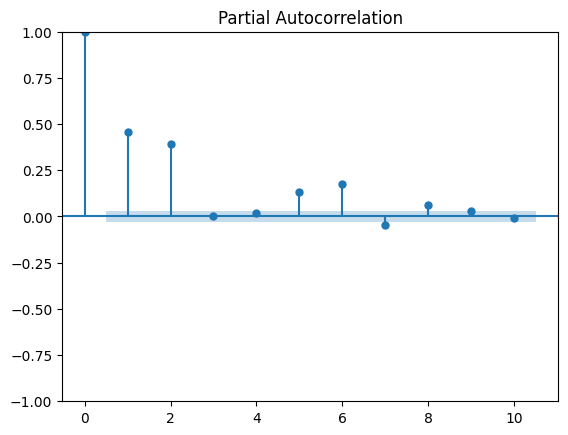

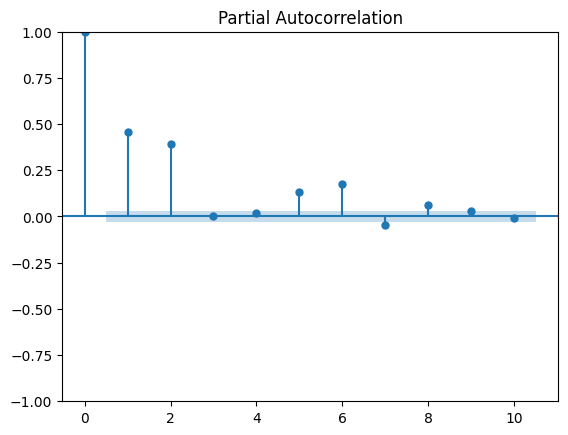

In [62]:
plot_pacf(data['Log_Returns'].dropna()**2, lags=10)

## Perform rolling forecast to better test the model.

We partition the time series into a train and test set. For each point $t$ in our test set, a separate model is fit using the time series from $T=0$ to $T=t-1$ before predicting the volatility at that time $t$.

In [64]:
test_size = int(len(log_returns) * 0.2)
rolling_predictions = []

for i in range(test_size):
    y = log_returns[:-(test_size-i)]
    model = arch_model(100*y, vol='GARCH', mean='AR', p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=data.index[-test_size:])


<Figure size 640x480 with 0 Axes>

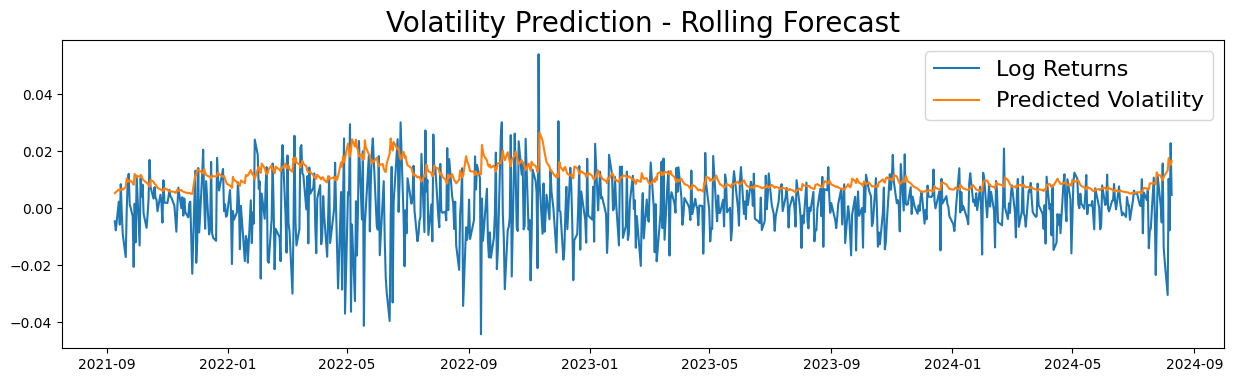

In [65]:
plt.figure()

fig, axs = plt.subplots(figsize=(15,4))

plt.plot(log_returns[-test_size:])
plt.plot(rolling_predictions/100)

plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['Log Returns', 'Predicted Volatility'], fontsize=16)

plt.show()

## Add sentiment as an exogenous variable to the GARCH model.

Note that due to limiations in the python library, we are adding the exogenous variable to the mean model (i.e. as an ARX mean model) 

In [81]:
# Load the data
sentiment_df = pd.read_csv('../data/nyt_sentiment.csv')
sentiment_df.index = pd.DatetimeIndex(sentiment_df['adjusted_date'])

sentiment_df.head()

,adjusted_date,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment
adjusted_date,,,,
2023-08-18,2023-08-18,0.029191,0.620925,0.349884
2023-08-19,2023-08-19,0.747801,0.153354,0.098845
2023-08-21,2023-08-21,0.125991,0.345267,0.528741
2023-08-22,2023-08-22,0.297633,0.321896,0.380470
2023-08-23,2023-08-23,0.049287,0.607605,0.343108


In [82]:
# Merge with time series.
data.index = pd.DatetimeIndex(data.index.tz_localize(None))
data_with_sentiment = data.join(sentiment_df, how='inner')

data_with_sentiment.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Log_Returns,adjusted_date,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment
2023-08-18,4344.879883,4381.819824,4335.310059,4369.709961,3940400000,0.0,0.0,-0.000149,2023-08-18,0.029191,0.620925,0.349884
2023-08-21,4380.279785,4407.549805,4360.299805,4399.770020,3726850000,0.0,0.0,0.006856,2023-08-21,0.125991,0.345267,0.528741
2023-08-22,4415.330078,4418.589844,4382.770020,4387.549805,3522760000,0.0,0.0,-0.002781,2023-08-22,0.297633,0.321896,0.380470
2023-08-23,4396.439941,4443.180176,4396.439941,4436.009766,3837270000,0.0,0.0,0.010984,2023-08-23,0.049287,0.607605,0.343108
2023-08-24,4455.160156,4458.299805,4375.549805,4376.310059,3723470000,0.0,0.0,-0.013549,2023-08-24,0.202811,0.250302,0.546887


We create a realised volatility time series, which is equal to the standard deviation of log returns for the past $n$ days, allowing us to benchmark the predictions (although we need to check the correctness of this method) 

In [83]:
log_returns_with_sentiment = data_with_sentiment['Log_Returns']
exog = data_with_sentiment[['mean_pos_sentiment',	'mean_neg_sentiment',	'mean_neutral_sentiment']]

realized_volatility_lag = 8
realized_volatility = log_returns.rolling(realized_volatility_lag).std()

In [103]:
test_size = int(len(log_returns_with_sentiment)*0.25)
rolling_predictions = []

for i in range(test_size-1):
    
    y = log_returns_with_sentiment[:-(test_size-i)]
    X = exog[:-(test_size-i)]

    model = arch_model(100*y, vol='GARCH', mean='ARX', x=X, p=1, q=1)
    #model = arch_model(100*y, vol='GARCH', p=1, q=1)
    model_fit = model.fit(disp='off')
    
    if i == test_size-2:  # Only print the last model fit summary for conciseness.
        print(model_fit.summary())

    pred = model_fit.forecast(horizon=1, x=exog[-test_size:].iloc[i+1].to_numpy().reshape((3,1,1)))
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))


                          AR-X - GARCH Model Results                          
Dep. Variable:            Log_Returns   R-squared:                       0.002
Mean Model:                      AR-X   Adj. R-squared:                 -0.010
Vol Model:                      GARCH   Log-Likelihood:               -275.824
Distribution:                  Normal   AIC:                           565.647
Method:            Maximum Likelihood   BIC:                           590.127
                                        No. Observations:                  244
Date:                Thu, Oct 17 2024   Df Residuals:                      240
Time:                        11:43:23   Df Model:                            4
                                         Mean Model                                        
                              coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------------------
Const        

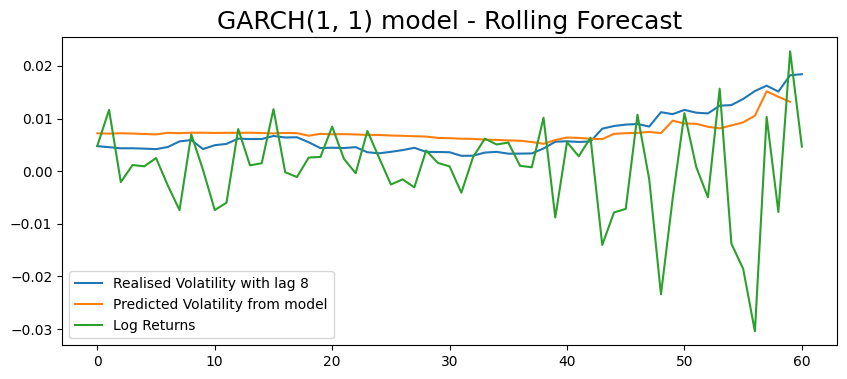

In [98]:
plt.figure(figsize=(10,4))

plt.plot(realized_volatility[-test_size:].reset_index(drop=True), label=f'Realised Volatility with lag {realized_volatility_lag}')
plt.plot(np.array(rolling_predictions)/100, label='Predicted Volatility from model')
plt.plot(log_returns_with_sentiment[-test_size:].reset_index(drop=True), label='Log Returns')

plt.title('GARCH(1, 1) model - Rolling Forecast', fontsize=18)
plt.legend()

plt.show()

#### Plot of sentiment scores.

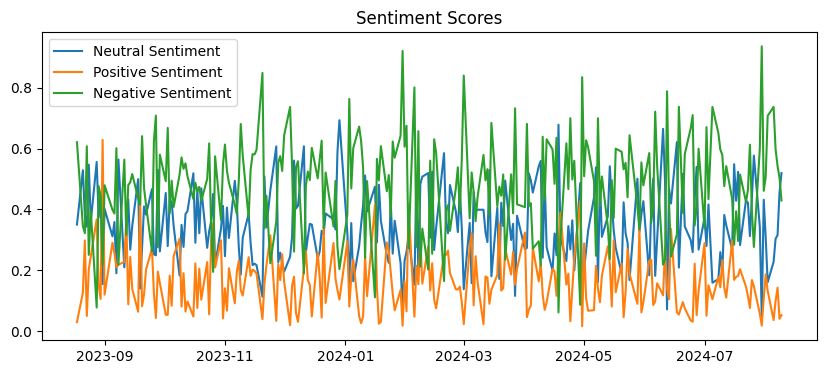

In [92]:
plt.figure(figsize=(10,4))

plt.plot(data_with_sentiment['mean_neutral_sentiment'], label='Neutral Sentiment')
plt.plot(data_with_sentiment['mean_pos_sentiment'], label='Positive Sentiment')
plt.plot(data_with_sentiment['mean_neg_sentiment'], label='Negative Sentiment')

plt.title("Sentiment Scores")
plt.legend()
plt.show()